In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#colab 압출 풀기
%cd /content/drive/MyDrive/image_dataset/
%mkdir /content/test_data
%mkdir /content/test_data/set_data
!unzip 'thermal_test_1116.zip' -d /content/test_data/set_data/test/

In [5]:
#코랩 경로 이동
%cd /content/drive/MyDrive/SR code/Super_Resolution_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid

import time
import math
from math import sqrt
from PIL import Image
import os
import random
from tqdm import tqdm

from util.normalization import image_normalization_extract
from util.util import data_loader_size
from util.metrics import psnr
from util.SSIM import ssim
from Dataset.image_dataset import imageDataset
from model.VDSR import VDSR
from model.SRCNN import SRCNN
from model.SRGAN import FeatureExtractor,ResidualBLock,GeneratorResNet,Discriminator
from vdsr_train import train,validate
from visualization.loss import Loss_and_metrics_visualization
from visualization.output import output_visualization

/content/drive/MyDrive/SR code/Super_Resolution_model


In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(98) # Seed 고정

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
check_point = True
save_path = '/content/drive/MyDrive/SR code/Super_Resolution_model'
#path
# image_path = r"C:\Users\microsoft\Desktop\이삿짐\code\songsan_project\test\\"
# image_path=r"C:\Users\microsoft\Desktop\이삿짐\code\songsan_project\New_Sample\원천데이터"
# image_path = '/content/drive/MyDrive/image_dataset/test_sensor'
# image_path = '/content/drive/MyDrive/image_dataset/train_dataset290'
image_path = '/content/test_data/set_data/test/'
image_size = (64,64)
Downsizing_factor = 4
num_epochs =400
batch_size = 32
b1 = 0.5
b2 =0.999
lr = 0.0002

cuda:0


In [14]:
# normalization
# nor_test_trans = transforms.Compose([transforms.Resize(image_size),
#                             transforms.ToTensor()])
# nor_test_data_set = torchvision.datasets.ImageFolder(root =image_path,
# 					transform = nor_test_trans,)
# nor_mean, nor_std = image_normalization_extract(nor_test_data_set)
nor_mean ,nor_std = ((0.5,0.5,0.5),(0.5,0.5,0.5))

# image Data load
#고해상도
HR_trans = transforms.Compose([transforms.Resize(image_size,interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean,nor_std)
                            ])
HR_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = HR_trans,
                    target_transform=None)
#저해상도
LR_trans = transforms.Compose([transforms.Resize((image_size[0]//Downsizing_factor,image_size[1]//Downsizing_factor)),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean, nor_std),
                            ])
LR_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = LR_trans,
                    target_transform=None)
#저해상도-bicubic 보간
LR_BICUBIC_trans = transforms.Compose([transforms.Resize((image_size[0]//Downsizing_factor,image_size[1]//Downsizing_factor)),
                            transforms.Resize(image_size,interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean, nor_std),
                            ])
LR_BICUBIC_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = LR_BICUBIC_trans,
                    target_transform=None)

# train valid test
validation_split = 0.2
test_split = 0.05

dataset_size=len(HR_data_set)
indices = list(range(dataset_size))
valid_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))

np.random.seed(98)
np.random.shuffle(indices)

train_idx,valid_idx,test_idx = indices[valid_split+test_split:],indices[:valid_split],indices[valid_split:valid_split+test_split]

#Dataset -> Dataloader
total_ds=imageDataset(LR_data_set, HR_data_set,LR_BICUBIC_data_set)

new_train_loader = DataLoader(Subset(total_ds,train_idx), batch_size=batch_size,shuffle=None)
new_valid_loader = DataLoader(Subset(total_ds,valid_idx), batch_size=batch_size,shuffle=None)
new_test_loader = DataLoader(Subset(total_ds,test_idx), batch_size=1,shuffle=None)

In [ ]:
project_name = 'test'
save_model_file_name='SRGAN_TEST11_16_thermal_image'
model = 'SRGAN'  # 대문자
check_point = True
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
cuda = torch.cuda.is_available()

generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(3, *image_size))
feature_extractor = FeatureExtractor()
feature_extractor.eval()

Gan_loss = torch.nn.BCELoss()
content_loss = torch.nn.L1Loss()

if cuda:
  generator = generator.cuda()
  discriminator = discriminator.cuda()
  feature_extractor=feature_extractor.cuda()
  Gan_loss = Gan_loss.cuda()
  content_loss = content_loss.cuda()
#
optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr,betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(b1,b2))
start = time.time()

generator_losses = []
discriminator_losses = []
metrics_valid = pd.DataFrame(data={'epoch':[],'PSNR':[],'SSIM':[]})
epoch_start = 0

if check_point ==True:
  check_point = torch.load(f'{save_path}/check_point/check_point_model_{model}_{project_name}.pt')
  generator.load_state_dict(check_point['generator'])
  optimizer_G.load_state_dict(check_point['optimizer_G'])
  discriminator.load_state_dict(check_point['discriminator'])
  optimizer_D.load_state_dict(check_point['optimizer_D'])
  generator_losses = check_point['generator_loss']
  discriminator_losses = check_point['discriminator_loss']
  epoch_start = check_point['epoch']
  metrics_valid = pd.read_csv(f'{save_path}/save_metrics/{model}_{project_name}_result.csv',index_col = 0)


for Epoch in range(epoch_start,num_epochs ):
    print(f'Epoch {Epoch+1} of {num_epochs}')
    discriminator.train()
    generator.train()
    running_loss_G = 0.0
    running_loss_D = 0.0
    for img in tqdm(new_train_loader):

        image = Variable(img[0].type(Tensor)).to(device)
        label = Variable(img[1].type(Tensor)).to(device)
        #image = img[0].type(Tensor).to(device)
        #label = img[1].type(Tensor).to(device)

        #valid = torch.ones((image.size()[0],*discriminator.output_shape), requires_grad =False).float().cuda()
        #fake = torch.zeros((image.size()[0],*discriminator.output_shape), requires_grad =False).float().cuda()
        valid = Variable(torch.Tensor(np.ones((image.size(0)))), requires_grad=False).cuda()
        fake = Variable(torch.Tensor(np.zeros((image.size(0)))), requires_grad=False).cuda()


        #train generators
        optimizer_G.zero_grad()

        gen_hr = generator(image)

        loss_GAN = Gan_loss(discriminator(gen_hr),valid)

        #Content_loss
        gen_feature = feature_extractor(gen_hr)
        real_feature = feature_extractor(label)
        loss_Content = content_loss(gen_feature,real_feature.detach())

        #total loss
        loss_G = loss_Content + 0.001* loss_GAN

        loss_G.backward()
        optimizer_G.step()

        #train Discriminator
        optimizer_D.zero_grad()

        loss_real = Gan_loss(discriminator(label),valid)
        loss_fake = Gan_loss(discriminator(gen_hr.detach()),fake)

        #total loss
        loss_D = (loss_real + loss_fake) /2

        loss_D.backward()
        optimizer_D.step()

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()
    final_running_loss_G = running_loss_G/len(new_train_loader.sampler)
    generator_losses.append((Epoch,final_running_loss_G))
    final_running_loss_D = running_loss_D/len(new_train_loader.sampler)
    discriminator_losses.append((Epoch,final_running_loss_D))
    end = time.time()
    print(f'Train loss_G : {final_running_loss_G:.4f}, Train loss_D : {final_running_loss_D:.10f} ,Time : { end-start:.2f} sec')
    # check point
    check_point = {'generator' : generator.state_dict(), 'optimizer_G' : optimizer_G.state_dict(), 'discriminator': discriminator.state_dict(),
                   'optimizer_D': optimizer_D.state_dict(), 'generator_loss':generator_losses, 'discriminator_loss':discriminator_losses,
                   'epoch':Epoch }
    torch.save(check_point, f'{save_path}/check_point/check_point_model_{model}_{project_name}.pt')


    # validation
    if Epoch % 2 == 0:
      with torch.no_grad():
        generator.eval()
        discriminator.eval()
        img_count=0
        psnr_avg = 0.0
        ssim_avg=0.0
        # ssim = 0.0
        for img in new_valid_loader:
          LR_image = img[0].to(device)
          label = img[1].to(device)
          sr_image = generator(LR_image)
          psnr_avg +=psnr(label,sr_image)
          ssim_avg +=ssim(label,sr_image).item()
          img_count+=1
          LR_image = nn.functional.interpolate(LR_image,scale_factor=4)
          sr_image = make_grid(sr_image,nrow=1, normalize=True)
          LR_image = make_grid(LR_image, nrow=1, normalize=True)
          img_grid = torch.cat((LR_image,sr_image),-1)
          save_image(img_grid,f'{save_path}/save_img/{model}/{model}_{project_name}_{Epoch}.png',normalize=False)
        psnr_avg /= img_count
        ssim_avg /= img_count
        print(f'PSNR_valid:{psnr_avg:.4f}, SSIM_valid:{ssim_avg:.4f}' )
        metrics_valid_update = pd.DataFrame(data={'epoch':[Epoch],'PSNR':[psnr_avg],'SSIM':[ssim_avg]})
        metrics_valid = pd.concat([metrics_valid,metrics_valid_update])
        metrics_valid.to_csv(f'{save_path}/save_metrics/{model}_result.csv')

#model save
torch.save(generator.state_dict(), f'{save_path}/save_model/SRGAN/{save_model_file_name}.pt')



torch.Size([3, 16, 16])


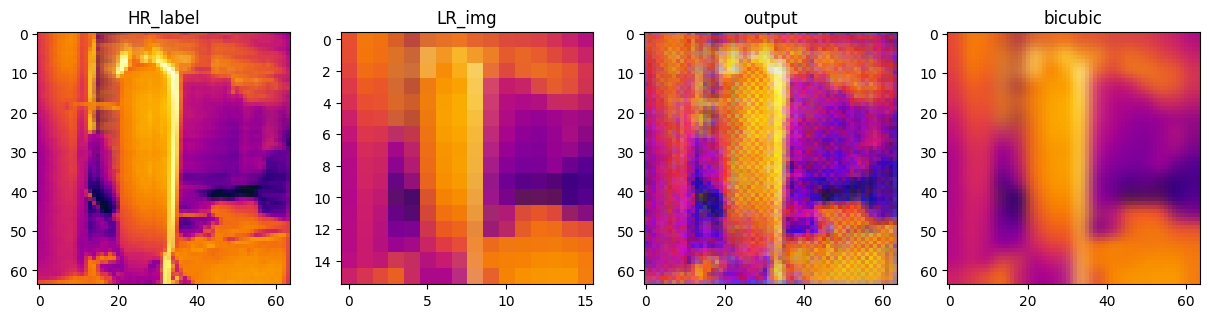

PSNR
output: 18.056330911288903
torch.Size([3, 16, 16])


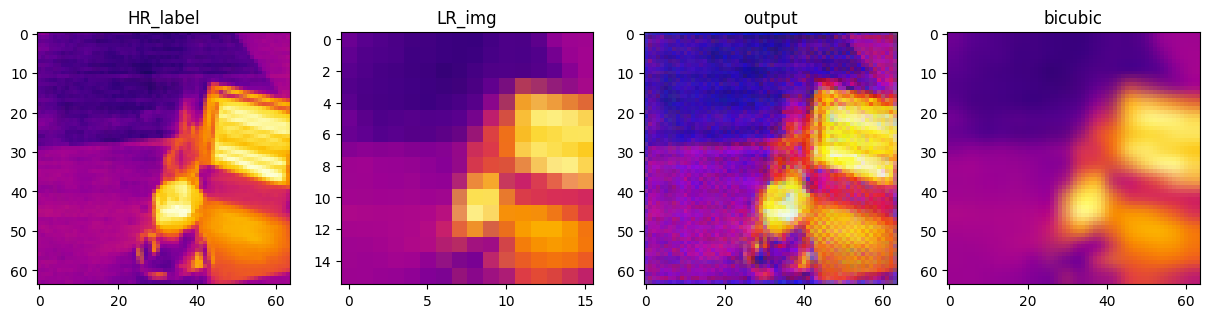

PSNR
output: 18.964775916449735
torch.Size([3, 16, 16])


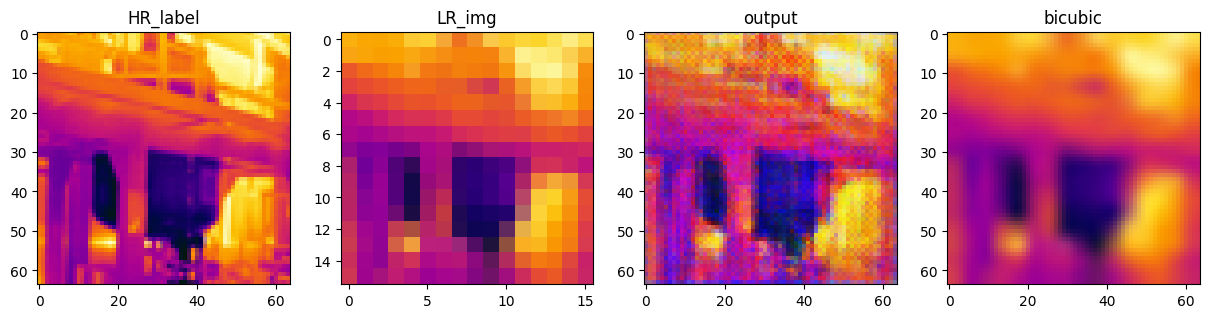

PSNR
output: 16.874064989573576
torch.Size([3, 16, 16])


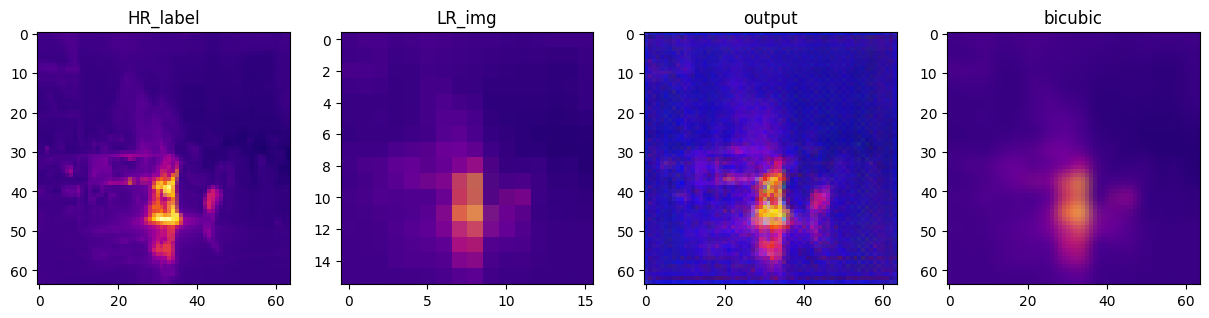

PSNR
output: 18.403038360632664
torch.Size([3, 16, 16])


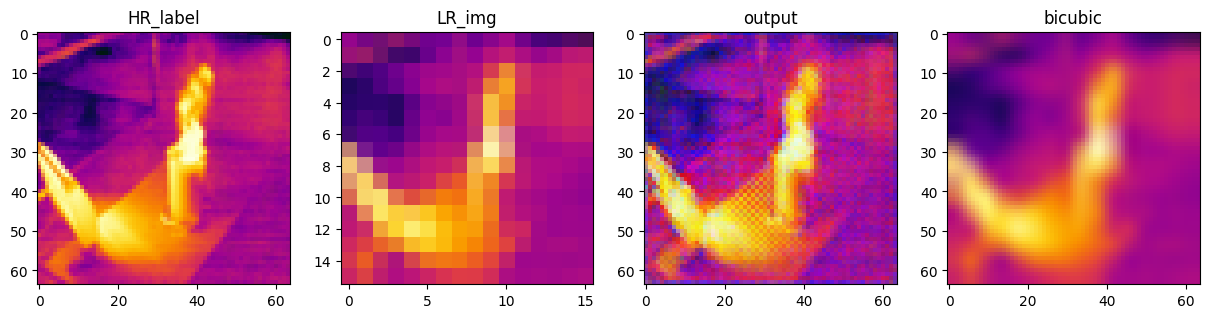

PSNR
output: 18.776972815186376


In [19]:
#generator
count =0
for img , label,bicu_img in new_valid_loader:
    img= img[0]
    print(img.shape)
    label = label[0]
    bicu_img=bicu_img[0]
    generator.eval()
    with torch. no_grad():
        img_ = img.unsqueeze(0)
        img_ = img_.to(device)
        output = generator(img_)
        output = output.squeeze(0)
    output_visualization(label,img,output,bicu_img,nor_mean,nor_std)
    count +=1
    if count == 5:
      break

In [ ]:
#model load
generator = GeneratorResNet()
generator.load_state_dict(torch.load('/content/drive/MyDrive/SR code/Super_Resolution_model/save_model/SRGAN/SRGAN_TEST11_16_thermal_image.pt',map_location=device))
generator=generator.to(device)
generator.eval()

In [ ]:
#model save
#torch.save(generator.state_dict(), '/content/drive/MyDrive/save_model/SR(Super resolution)/SRGAN/SRGAN_TEST11_15_thermal_image.pt')

# SRCNN &VDSR

In [ ]:
#model = SRCNN().to(device)
model = VDSR().to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,
                                        step_size = num_epochs//4,
                                        gamma = 0.1,
                                        verbose = False )

train_loss, val_loss = [],[]
train_psnr, val_psnr = [],[]
train_ssim, val_ssim = [],[]
best_loss= 0.0
best_model = None
start = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} of {num_epochs}')
    train_epoch_loss, train_epoch_psnr,train_epoch_ssim = train(model=model,
                                                                data_dl=new_train_loader,
                                                                optimizer=optimizer,
                                                                device=device,
                                                                loss_func=loss_func)
    scheduler.step()
    print("lr: ", optimizer.param_groups[0]['lr'])
    val_epoch_loss, val_epoch_psnr,val_epoch_ssim = validate(model=model,
                                                             data_dl=new_valid_loader,
                                                             device=device,
                                                             loss_func=loss_func,
                                                             epoch=epoch
                                                             )

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    train_ssim.append(train_epoch_ssim)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    val_ssim.append(val_epoch_ssim)

    end = time.time()
    print(f'Train loss : {train_epoch_loss:.4f}, Valid loss : { val_epoch_loss:.3f}')
    print(f'Train SSIM : {train_epoch_ssim:.4f}, Valid SSIM : { val_epoch_ssim:.3f}')
    print(f'Train PSNR : {train_epoch_psnr:.4f}, Valid PSNR : { val_epoch_psnr:.3f}, Time : { end-start:.2f} sec')

    if best_loss < val_epoch_psnr:
            best_loss = val_epoch_psnr
            best_model = model


In [ ]:
# Loss and metrics visualization
Loss_and_metrics_visualization(train_loss,train_psnr,train_ssim,val_loss,val_psnr,val_ssim)

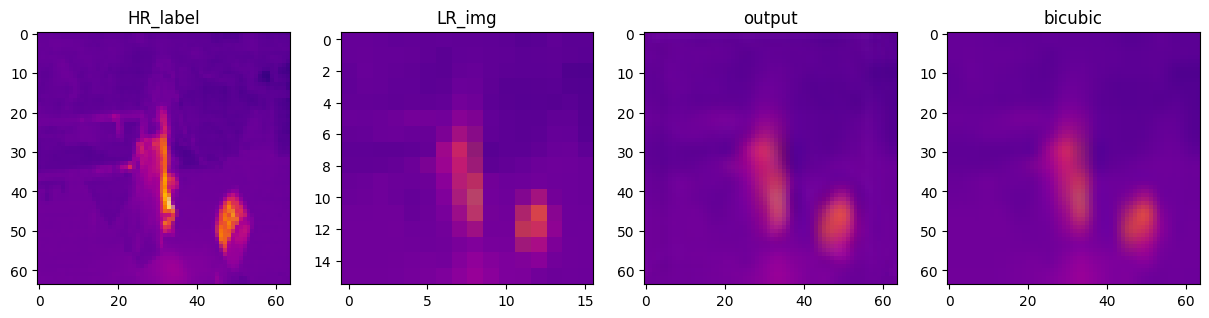

PSNR
output: 27.368612890677383


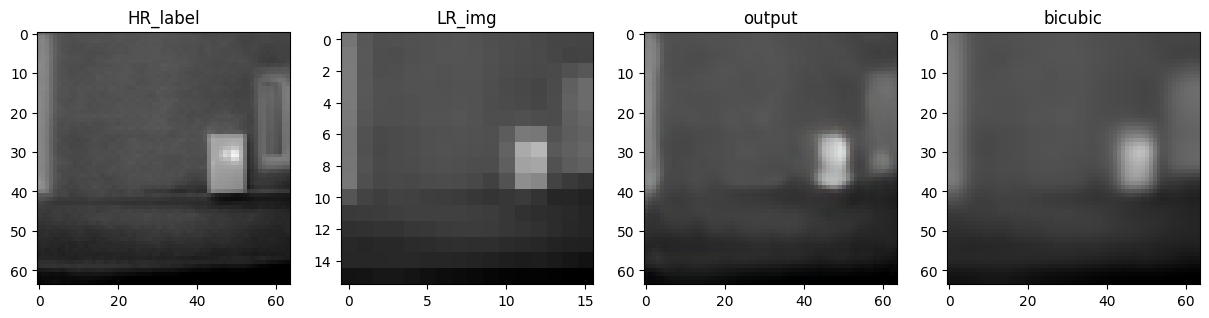

PSNR
output: 30.173589406949006


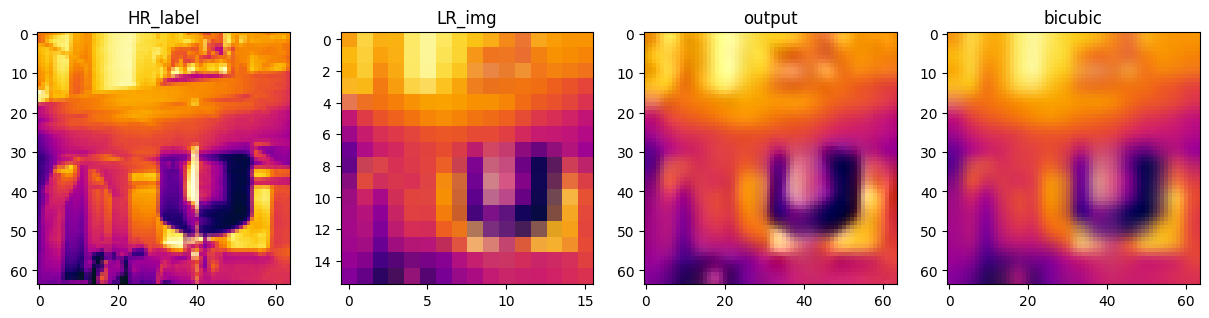

PSNR
output: 20.443967688370872


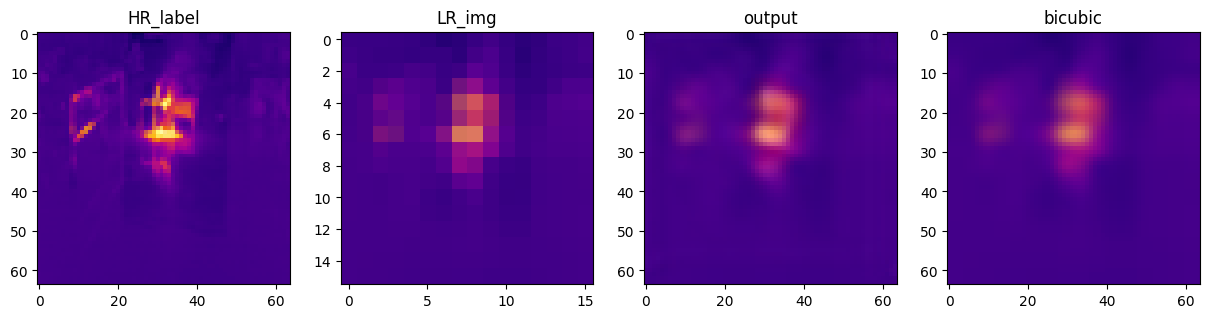

PSNR
output: 27.53016884552713


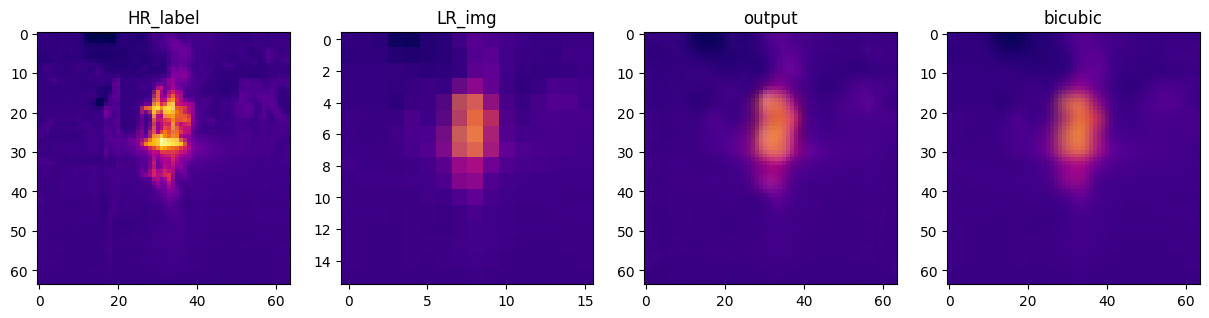

PSNR
output: 27.369057449279897


In [ ]:
#inference - vdsr
count = 0
for img , label,bicu_img in new_valid_loader:
    img= img[3]
    label = label[3]
    bicu_img=bicu_img[3]
    model.eval()
    with torch. no_grad():
        img_ = bicu_img.unsqueeze(0)
        img_ = img_.to(device)
        output = model(img_)
        output = output.squeeze(0)
    output_visualization(label,img,output,bicu_img,nor_mean,nor_std)
    count +=1
    if count == 5:
        break


In [ ]:
#model save
torch.save(model.state_dict(), './vdsr_save_model/vdsr_epoch50_model.pt')

In [ ]:
model = VDSR().to(device)
#model = SRCNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/save_model/SR(Super resolution)/VDSR/vdsr_epoch100_model.pt'))
model.eval()

VDSR(
  (residual_layer): Sequential(
    (0): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (1): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (2): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (3): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (4): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (5): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (6): conv_Relu_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa